# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга**.

**Цель исследования** — ответить на следующие вопросы:
1. Есть ли зависимость между наличием детей и возвратом кредита в срок?
2. Есть ли зависимость между семейным положением и возвратом кредита в срок?
3. Есть ли зависимость между уровнем дохода и возвратом кредита в срок?
4. Как разные цели кредита влияют на его возврат в срок?

**Ход исследования**

Данные о клиентах банка содержатся в файле `data.csv`. Поскольку качество данных неизвестно, необходимо провести обзор данных перед началом исследования.
 
Исследование пройдёт в три этапа:
 1. Обзор данных.
 2. Предобработка данных.
 3. Ответы на вопросы заказчика.

**Оглавление**
 
1. [Обзор данных](#intro)
2. [Предобработка данных](#preprocessing)
    * [Обработка пропущенных значений](#null)
    * [Замена типа данных](#data_type)
    * [Обработка дубликатов](#duplicates)
    * [Лемматизация](#lemma)
    * [Категоризация данных](#categorization)
3. [Ответы на вопросы](#questions)
4. [Общий вывод](#conclusion)

## Шаг 1. Обзор данных 
<a id='intro'></a>

In [189]:
# импорт библиотеки pandas
import pandas as pd

In [190]:
# чтение файла с данными и сохранение в df
df = pd.read_csv('/datasets/data.csv')

In [191]:
# получение первых 10 строк таблицы df
df.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


In [192]:
# получение общей информации о данных в таблице df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


**Общая информация**

В таблице двенадцить столбцов.

Типы данных: 
- `int64` — `children`,  `dob_years`, `education_id`, `family_status_id `, `debt`;
- `float64` — `days_employed` и `total_income`;
- `object` — `education`, `family_status`, `gender`, `income_type`, `purpose`.

Согласно документации к данным:
- `children` — количество детей в семье;
- `days_employed` — общий трудовой стаж в днях;
- `dob_years` — возраст клиента в годах;
- `education` — уровень образования клиента;
- `education_id` — идентификатор уровня образования;
- `family_status` — семейное положение;
- `family_status_id` — идентификатор семейного положения;
- `gender` — пол клиента;
- `income_type` — тип занятости;
- `debt` — имел ли задолженность по возврату кредитов (1 — имел, 0 — не было задолжностей);
- `total_income` — ежемесячный доход;
- `purpose` — цель получения кредита.

Таким образом, для исследования интересны данные в следующих столбцах: `children`, `family_status` (`family_status_id`), `total_income`, `purpose`, `debt`.

**Замечания**

* Стиль в названии колонок не нарушен.
* Количество значений в столбцах различается: в столбцах `days_employed` и `total_income` значений меньше, чем в остальных.
* В столбце `days_employed`, описывающем общий трудовой стаж наблюдаются отрицательные значения, что противоречит здравому смыслу. Кроме того, зачения указаны не в заявленном формате (количество дней). Во-первых, данные представляют собой формат `float`, а не ожидаемый `int`. Во-вторых, если предположить, что данные являются количеством дней стажа, в некоторых строках стаж составляет сотни лет. Вероятнее всего, данные представлены в формате UTC. Однако этот столбец не будет участвовать в исследовании.
* В столбце `purpose` встречаются различные формулировки одной и той же цели.
* В столбце `education` встречаются дубликаты в разных регистрах (этот столбец также не участвует в исследовании).

О вышеописанных проблемах с данными стоит сообщить коллегам, которые предоставили таблицу.

**Вывод**

Предварительно можно утверждать, что, данных достаточно для ответа на поставленные вопросы. Однако для дальнейшей работы, необходимо устранить проблемы в данных.

## Шаг 2. Предобработка данных 
<a id='preprocessing'></a>

### Обработка пропусков
<a id='null'></a>

**Общий обзор пропусков**

Сначала выясним, сколько в таблице пропусков.

In [193]:
# подсчет суммы и доли пропусков по колонкам
df.isna().agg(['sum', 'mean'])

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
sum,0.0,2174.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2174.000000,0.0
mean,0.0,0.100999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.100999,0.0


В интересующей нас колонке `total_income` и в `days_employed` доля пропусков 10% . Можно предположить, что пропуски в этих столбцах взаимосвязны.

**Обработка пропусков в столбце total_income**

Проверим, являются ли пропуски в столбце `total_income` показателем того, что клиенты, оставившие их, безработные. Сначала посмотрим на тип занятости, который указывают клиенты (возможно, среди них нет безработных).

In [194]:
df['income_type'].unique()

array(['сотрудник', 'пенсионер', 'компаньон', 'госслужащий',
       'безработный', 'предприниматель', 'студент', 'в декрете'],
      dtype=object)

Посмотрим, кто оставляет пропуски в колонке дохода и сколько их.

In [195]:
df[df['total_income'].isna()]['income_type'].value_counts()

сотрудник          1105
компаньон           508
пенсионер           413
госслужащий         147
предприниматель       1
Name: income_type, dtype: int64

Итак, пропуски в столбце `total_income` отражают клиентов, по каким-либо причинам не пожелавших предоставить информацию о своем доходе.

Возможные варианты  обработки пропусков в столбце `total_income`:
- При удалении строк с пропусками в `total_income` из таблицы пропадет часть данных в других столбцах, что может негативно сказаться на исследование.
- Можно заполнить эти пропуски медианой или средним, но это повлияет на зависимость возврата кредита в срок от дохода. Заполнять их нулями было бы некорректно, полскольку нельзя с уверенностью утверждать, что у данных клиентов "нулевой доход".
- Сроки со значением NaN в столбце `total_income` можно оставить в покое, но это будет неудобно для дальнейших действий.

Попробуем два наиболее удобных, на мой взгляд, подхода и сравним, какой лучше.

**Первый подход**

Поскольку вопросы, на которые предстоит ответить таковы, что каждый раз необходимо рассматривать взаимодействие между одним из четырех столбцов и столбцом `debt`, можно выделить в отдельную таблицу столбцы `total_income` и `debt`. Таким образом, в колонке с доходом можно будет исключить строки с пропусками, но при этом не удалять строки при работе с другими столбцами.

In [196]:
# сохраним столбецы total_income и debt в отдельную таблицу
income_all = df[['total_income', 'debt']]
income_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 2 columns):
total_income    19351 non-null float64
debt            21525 non-null int64
dtypes: float64(1), int64(1)
memory usage: 336.5 KB


In [197]:
income_all.head(10)

,total_income,debt
0,253875.639453,0
1,112080.014102,0
2,145885.952297,0
3,267628.550329,0
4,158616.077870,0
5,255763.565419,0
6,240525.971920,0
7,135823.934197,0
8,95856.832424,0
9,144425.938277,0


Отдельно сохраним строки с пропусками, чтобы позже их проанализировать.

In [198]:
# сохранение строк с пропусками с отдельную таблицу
income_nan = income_all[ income_all['total_income'].isna()]

In [199]:
#проверка число пропусков
income_nan['debt'].count()

2174

Удалим все нулевые значения из таблицы `income` (их 10% от числа всех строк).

In [200]:
# удаление строк с пропусками
income = income_all.dropna()

In [201]:
# проверка на наличие пропусков
income['total_income'].isna().sum()

0

In [202]:
income.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19351 entries, 0 to 21524
Data columns (total 2 columns):
total_income    19351 non-null float64
debt            19351 non-null int64
dtypes: float64(1), int64(1)
memory usage: 453.5 KB


**Второй подход**

Заменим нули на медианное значение, поскольку оно наиболее объективно описывает уровень дохода.

In [203]:
# расчет медианы
total_income_median= df['total_income'].median()
total_income_median

145017.93753253992

In [204]:
# заполнение пропусков
df['total_income'] = df['total_income'].fillna(total_income_median)

Сначала сгруппируем данные по `income_type` и посчитаем в каждой группе медиану.

In [205]:
income_type_group = df.groupby('income_type')['total_income'].agg(['median'])

Добавим название каждой группы в столбец

In [206]:
income_type_group['income_type'] = income_type_group.index

In [207]:
income_type_group

,median,income_type
income_type,,
безработный,131339.751676,безработный
в декрете,53829.130729,в декрете
госслужащий,145017.937533,госслужащий
компаньон,162401.351555,компаньон
пенсионер,128747.675570,пенсионер
предприниматель,322090.541240,предприниматель
сотрудник,145017.937533,сотрудник
студент,98201.625314,студент


Создадим список списков, в каждом из которых первый элемент - медиана, второй - название группы

In [208]:
income_type_group_list = income_type_group.values.tolist()
income_type_group_list

[[131339.7516762103, 'безработный'],
 [53829.13072905995, 'в декрете'],
 [145017.93753253992, 'госслужащий'],
 [162401.35155456822, 'компаньон'],
 [128747.67556966442, 'пенсионер'],
 [322090.5412398128, 'предприниматель'],
 [145017.93753253992, 'сотрудник'],
 [98201.62531401133, 'студент']]

Функция, возвращаюшая медиану соответствующей группы. 

In [214]:
def fill_total_income(row):
    '''
    Функция ищет соотвествие значения столбца income_type со значением 
    из списка income_type_group_list и возвращает медиану для соответсвующей группы
    '''
    for el in income_type_group_list:
        if row['income_type'] == el[1]:
            return el[0]
    

In [215]:
df_training = pd.read_csv('/datasets/data.csv')

In [216]:
df_training[df_training['total_income'].isna()]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21489,2,NaN,47,Среднее,1,женат / замужем,0,M,компаньон,0,NaN,сделка с автомобилем
21495,1,NaN,50,среднее,1,гражданский брак,1,F,сотрудник,0,NaN,свадьба
21497,0,NaN,48,ВЫСШЕЕ,0,женат / замужем,0,F,компаньон,0,NaN,строительство недвижимости
21502,1,NaN,42,среднее,1,женат / замужем,0,F,сотрудник,0,NaN,строительство жилой недвижимости


In [217]:
# запонение нулей в столбце total_income значениями, которые возвращает функция fill_total_income. Функции передаются только нулевые строки
df_training['total_income'] = df_training['total_income'].fillna(df[(df_training['total_income'].isna())].apply(fill_total_income, axis=1))

In [218]:
# проверка отдельных строк
df_training.loc[21510, ['income_type', 'total_income']]

income_type     сотрудник
total_income       145018
Name: 21510, dtype: object

In [219]:
# визуальная проверка таблицы
df_training.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


In [220]:
# проверка на отсутствие нулей
df_training['total_income'].isna().sum()

0

**Пропуски  в других столбцах**

Cтолбцы `family_status` и `purpose` имеют тип данных `object`. При использовании стандартного метода `isna()` пропусков в них не было найдено. Посмотрим на их уникальные значения, поскольку есть вероятность, что попуски обозначены не типом `None`, а каким-либо другим способом. <a id='second'></a>

In [221]:
# уникальные значения
df['family_status'].unique()

array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'Не женат / не замужем'], dtype=object)

In [222]:
# уникальные значения
df['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

Итак, в интересных для наблюдения столбцах типа данных `object` других пропусков не найдено.

Столбец `children`, как и столбцы с обозначением id, имеет тип данных `int`, при использовании метода `isna()` пропусков в них найдено не было. Нули в этоих колонках не являются пропуском.

Рассмотрим другие колонки.

Пропуски в `days_employed` не повлияют на ход исследования. Кроме того, данные в этом столбце не наглядны. Удалим его.

In [223]:
# удаление столбца
df = df.drop('days_employed', axis=1)

In [224]:
# визуальная проверка
df.head()

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


Из других признаков интересно отметить столбец `dob_years`, в котором хранится возраст клиентов. Он может содержать нули, которые будут означать пропуски в данных.

In [225]:
# доля строк с заданным значением
(df[df['dob_years'] == 0]['dob_years'].count()) / len(df) * 100

0.4692218350754936

Пропуски (или возможно опечатки) в столбце `dob_years` найдены в менее, чем в 1% проценте строк. Поскольку для ответа по поставленные вопросы этот столбец не нужен, оставим эти строки, чтобы не потерять данные других признаков.

Уникальные занчения столбца `income_type` уже были представлены, пропусков в них не было.

Проверим значения столбца `gender`

In [226]:
# уникальные значения
df['gender'].unique()

array(['F', 'M', 'XNA'], dtype=object)

In [227]:
# визуальная оценка строк
df[df['gender'] == 'XNA'].head(10)

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
10701,0,24,неоконченное высшее,2,гражданский брак,1,XNA,компаньон,0,203905.157261,покупка недвижимости


Значение `'XNA'` встречается один раз. Возможно, это не пропуск, а намеренное решение не указывать пол. Поскольку в исследовании признак принимать участия не будет, оставим его тоже без изменений.

**Вывод**

Пропуски были обнаружены в столбце `total_income`, задействованном в исследовании. Применено два подхода по устранению пропусков в этом столбце. Первый подход: убрать строки с пропусками, предварительно выделив этот столбец вместе со столбцом `debt` в отдельную таблицу для того, чтобы не удалять данные из других столбцов общей таблицы. Второй подход, замена пропусков на медианные значения этого столбца. 

Коме того, найдены пропуски в столбцах, не задействованных в исследовании. О них стоит сообщить коллегам.

### Замена типа данных
<a id='data_type'></a>

Для наглядности можно округлить значения в столбце `total_income`, поскольку данные представлены с точностью до шестого знака после запятой. Проебразуем данные в тип `int` методом `astype`, поскольку он позволит преобразовать тип `float` всего столбца в `int`.

In [228]:
# замена типа данных столбца на int
df['total_income'] = df['total_income'].astype('int')

In [229]:
# визуальная проверка
df['total_income'].head()

0    253875
1    112080
2    145885
3    267628
4    158616
Name: total_income, dtype: int64

Аналогично заменим тип данных столбца `total_income` и в таблице `income`.

In [230]:
# замена типа данных столбца на int
income['total_income'] = income['total_income'].astype('int')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [231]:
# визуальная проверка
income['total_income'].head()

0    253875
1    112080
2    145885
3    267628
4    158616
Name: total_income, dtype: int64

**Вывод**

Заменен тип данных в столбце `total_income` на целочисленный для простоты и большей наглядности.

### Обработка дубликатов
<a id='duplicates'></a> 

Воспользуемся ручным поиском дубликатов для выявления наявных повторяющихся значений в некоторых столбцах. 

Оценим число различных значений в столбце `children`

In [232]:
# подсчет числа уникальных значений столбца
df['children'].value_counts()

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

В столбце наблюдаются необычные значения: -1 и 20. 

Посмотрим на строки со значением -1 в столбце `children`.

In [233]:
# вывод строк с заданным значением
df[df['children'] == -1].head()

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
291,-1,46,среднее,1,гражданский брак,1,F,сотрудник,0,102816,профильное образование
705,-1,50,среднее,1,женат / замужем,0,F,госслужащий,0,137882,приобретение автомобиля
742,-1,57,среднее,1,женат / замужем,0,F,сотрудник,0,64268,дополнительное образование
800,-1,54,среднее,1,Не женат / не замужем,4,F,пенсионер,0,86293,дополнительное образование
941,-1,57,Среднее,1,женат / замужем,0,F,пенсионер,0,145017,на покупку своего автомобиля


По всей видимости, значение " -1 " является опечаткой. Заменим его на " 1 ".

In [234]:
# замена значений в колонке методом replace
df['children'] = df['children'].replace(-1, 1)

In [235]:
# проверка на наличие замененного значения
df[df['children'] == -1]['children'].count()

0

Перейдем к вопросу о многодетных семья. В таблице найдено 76 строк со значением 20 в колонке `children`. На запрос "самые большие семьи России" поисковик выдает информацию единицах семьей. Семья с 20 детьми, как утверждается,  занесена в Книгу рекордов Гиннеса. Очевидно, что 76 клиентов не могут иметь столько детей. 

Можно утверждать, что значение " 20 " в колонке `children` тоже является опечаткой. Заменим это значение на " 2 ".

In [236]:
# замена значений в колонке методом replace
df['children'] = df['children'].replace(20, 2)

In [237]:
# проверка на наличие замененного значения
df[df['children'] == 20]['children'].count()

0

Посмотрим на уникальные значения столбцов с типом данных `object`. 

Уникальные значения столбца `family_status` и `income_type` были получены ранее, дубликатов там нет. 

В колонке `education` видны одинаковые значения в разных регистрах (см. ячейку ниже). Возможно, эта эти значения заполняются вручную, а не из предложенного списка.

In [238]:
# подсчет уникальных значений в столбце
df['education'].value_counts()

среднее                13750
высшее                  4718
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
Ученая степень             1
УЧЕНАЯ СТЕПЕНЬ             1
Name: education, dtype: int64

Приведем все строки к нижнему регистру.

In [239]:
# приведение строк в столбце к нижнему регистру
df['education'] = df['education'].str.lower()

In [240]:
# проверка уникальных значений
df['education'].value_counts()

среднее                15233
высшее                  5260
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64

Как было видно ранее, столбец `purpose` тоже содержит дубликаты, но для их выявления необходима лемматизация.

Проверим таблицу на наличие дубликатов методом duplicated().

In [241]:
# подсчет дубликатов в таблице
df.duplicated().sum()

71

In [242]:
# отношение строк-дубликатов к числу строк таблицы
(df.duplicated().sum()) / len(df) * 100

0.32984901277584205

Число таких строк увеличилось по сравнению с тем, что было до обработки отдельных столбцов и составляет 0,3% от размера таблицы.

 Удалим дубликаты.

In [243]:
# удаление дубликатов
df = df.drop_duplicates().reset_index(drop=True)

In [244]:
# подсчет дубликатов в таблице
df.duplicated().sum()

0

**Вывод**

Найденные дубликаты обработаны, однако остается проблема со столбцом `purpose`, для обработки которого понадобится лемматизация.

### Лемматизация
<a id='lemma'></a> 

Выведем уникальные значения столбца `purpose`.

In [245]:
df['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

Список целей может выглядеть компактней и наглядней, если они будут характеризоваться одним словом из ограниченного списка. Для этого приведем значения из списка уникальных целей к их словарной форме (лемме), выделим основные цели и перезапишем существующие цели в соответсвии с новым лаконичным списком.

Сначала подключим одну из библиотек с функцией лемматизации `pymystem3`.

In [246]:
# Получение стеммера/лемматизатора для слов на русском
from pymystem3 import Mystem
# переименование стеммера для простоты
m = Mystem()

Поскольку метод `unique` возвращает массив, сохраним значения этого метода в списке `purpose_list` для удобства работы.

In [247]:
# преобразование массива в список
purpose_list = df['purpose'].unique().flatten().tolist()

Выделим леммы для строк этого списка. Леммы будут сохранятся в новом списке `purpose_lemmas`. 

In [248]:
# лемматизация каждой строки из списка уникальных названий
purpose_lemmas = []
for el in purpose_list:
    purpose_lemmas.append(m.lemmatize(el))

Поскольку `pymystem3` возвращает список лемматизированных строк, на выходе из цикла `purpose_lemmas` будет являться списком списков. Преобразуем его обратно в список для простоты.

In [249]:
# преобразование списка списков в список
purpose_lemmas = sum(purpose_lemmas, [])

Посчитаем количество лемматизированных слов в `purpose_lemmas` с помощью контейнера `Counter`. Для этого подключим библиотеку `collections`.

In [250]:
# импорт контейнера Counter из модуля collections
from collections import Counter
# подсчет числа слов в лемматизированном списке
Counter(purpose_lemmas)

Counter({'покупка': 10,
         ' ': 59,
         'жилье': 7,
         '\n': 38,
         'приобретение': 1,
         'автомобиль': 9,
         'дополнительный': 2,
         'образование': 9,
         'сыграть': 1,
         'свадьба': 3,
         'операция': 4,
         'с': 5,
         'на': 4,
         'проведение': 1,
         'для': 2,
         'семья': 1,
         'недвижимость': 10,
         'коммерческий': 2,
         'жилой': 2,
         'строительство': 3,
         'собственный': 1,
         'подержать': 1,
         'свой': 4,
         'со': 1,
         'заниматься': 2,
         'сделка': 2,
         'подержанный': 1,
         'получение': 3,
         'высокий': 3,
         'профильный': 1,
         'сдача': 1,
         'ремонт': 1})

Просмотрев словарь метода `Counter`, можно выделить основные цели клиентов. Они характеризуются наиболее часто встречающими существительными:  'жилье', 'автомобиль', 'образование', 'свадьба', 'недвижимость'. Также надо заметить, что 'жилье' и 'недвижимость' синонимичные понятия, это нужно участь при замене исходного столбца таблицы. 

Итак, новый список целей для получения кредита будет выглядеть следующим образом:

In [251]:
purpose_list = ['недвижимость', 'автомобиль', 'образование', 'свадьба']

Этот же список можно было составить без вышеперечисленных действий, изучив результат вывода метода `unique`. Однако изучение вывода `Counter` проще, чем чтение вывода `unique`.

Теперь необходимо земенить цели в столбце `purpose` исходной таблицы на унифицированные значения из списка `purpose_list`. Для этого нужно лемматизировать каждую строку в стоблце `purpose`, сверить с имеющимися целями и переприсвоить новое значение.

Напишем функцию, которая будет искать в переданнном ей списке слова `'жилье', 'недвижимость', 'автомобиль', 'образование', 'свадьба'`  и возвращать соответствующие слова из списка `purpose_list`. 

In [252]:
# функция find_purpose 
def find_purpose(row):
    
    """ 
    Принимает сторку, которую лемматизирует. 
    В списке лемм ищет совпадения со списком purpose_list и возвращает соответсвующее значение.
    Если в принятой строке встречается слово 'жилье', возвращает нулевой элемент purpose_list
    """
    
    lemma = m.lemmatize(row)
    for el in purpose_list:
        if el in lemma:
            return el
        if 'жилье' in lemma:
            return purpose_list[0]

Поскольку функция `find_purpose` работает исправно, можно передать ее методу `apply`  и применить к исходному столбцу `purpose`. Результат функции так же сохраняется в столбце `purpose`.

In [254]:
# запись новых значений в столбец purpose
df['purpose'] = df['purpose'].apply(find_purpose)

In [255]:
# проверка работы цикла
df['purpose'].unique()

array(['недвижимость', 'автомобиль', 'образование', 'свадьба'],
      dtype=object)

**Вывод**

Строки в столбце `purpose` лемматизированы. Значения столбца  `purpose` приведены в порядок. Таким образом, данные подготовлены к дальнейшей обработке.

### Категоризация данных  
<a id='categorization'></a>

Для столбцов `family_status` и `family_status_id` cоздадим отдельный «словарь», где названию статуса будет соответствовать id номер. В дальнейшем будем работать с `family_status_id`, поскольку обращаться к данным типа `int` будет проще, чем к длинной строке.

In [256]:
# создание отдельной таблицы с колонками family_status_id и family_status
family_dict = df[['family_status_id','family_status']]

In [257]:
# визуальная проверка новой таблицы
family_dict.head()

,family_status_id,family_status
0,0,женат / замужем
1,0,женат / замужем
2,0,женат / замужем
3,0,женат / замужем
4,1,гражданский брак


Поскольку таблица `family_dict` содержит столько же строк, сколько и исходная таблица, необходимо удалить дубликаты, чтобы выделить соответствие id с его значением.

In [258]:
# удаление дубликатов и упорядочевание индексов
family_dict = family_dict.drop_duplicates().reset_index(drop=True)

In [259]:
# вывод таблицы
family_dict

,family_status_id,family_status
0,0,женат / замужем
1,1,гражданский брак
2,2,вдовец / вдова
3,3,в разводе
4,4,Не женат / не замужем


Теперь `family_dict` является "словарем", с помощью которого легко расшифровать  id семейного статуса.

Такой же словарь можно было бы сделать и для столбца `purpose`, назначив каждому из четырех значений свой id. К счастью, зачения в этом столбце — единичные слова, а не целые строки.

Столбец, характеризующий доход клиентов, тоже разобьем на группы. Сначала посмотрим, какие значения принимает этот столбец.

In [260]:
# основные статистические характеристики столбца total_income
df['total_income'].describe()

count    2.145400e+04
mean     1.652256e+05
std      9.802102e+04
min      2.066700e+04
25%      1.076230e+05
50%      1.450170e+05
75%      1.958132e+05
max      2.265604e+06
Name: total_income, dtype: float64

Итак, минимальное значение около 20 тысяч, максимальное около 2 миллионов, среднее (и медианное) около 150 тысяч. Разобъем данные, опираясь на эти значения.

Столбец, характеризующий доход клиентов, тоже разобьем на группы:
* Доход до 50 тысяч;
* Доход от 50 до 100 тысяч;
* Доход от 100  до 200 тысяч;
* Доход от 200  до 500 тысяч;
* Доход от 500 тысяч до 1 миллиона;
* Доход более 1 миллиона.

Напишем функцию, которая будет принимать доход, а возвращать группу, к которой относится клиент.

In [261]:
# функция income_group
def income_group(tot_inc):
    
    """
    Принимает сумму дохода tot_inc и возвращает группу, к которой относится клиент с данным доходом:
    * Доход до 50 тысяч — '< 50 тыс' ;
    * Доход от 50  до 100 тысяч — '50 - 100 тыс';
    * Доход от 100  до 200 тысяч — '100 - 200 тыс';
    * Доход от 200  до 500 тысяч — '200 - 500 тыс' ;
    * Доход от 500 тысяч до 1 миллиона — '500 тыс - 1 млн';
    * Остальные случаи — '> 1 млн'.    
    """
    
    if tot_inc < 50000:
        return '< 50 тыс'
    if 50000 <= tot_inc < 100000:
        return '50 - 100 тыс'
    if 100000 <= tot_inc < 200000:
        return '100 - 200 тыс'
    if 200000 <= tot_inc < 500000:
        return '200 - 500 тыс'
    if 500000 <= tot_inc < 1000000:
        return '500 тыс - 1 млн'
    return '> 1 млн'

In [262]:
# проверка работы функции
income_group(1500000)

'> 1 млн'

Функция работает корректно. Передадим ей столбец `total_income` и перезапишем в него новые значения.

In [263]:
df['total_income_group'] = df['total_income'].apply(income_group)

То же сделаем и с таблицей income

In [264]:
income['total_income_group'] = income['total_income'].apply(income_group)
income.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,total_income,debt,total_income_group
0,253875,0,200 - 500 тыс
1,112080,0,100 - 200 тыс
2,145885,0,100 - 200 тыс
3,267628,0,200 - 500 тыс
4,158616,0,100 - 200 тыс


Удалим все лишние столбцы из исходной таблицы.

In [265]:
# удаление столбцов
df = df.drop(['family_status', 'education', 'education_id', 'dob_years', 'gender', 'income_type', 'total_income'], axis=1)

In [266]:
# проверка
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21454 entries, 0 to 21453
Data columns (total 5 columns):
children              21454 non-null int64
family_status_id      21454 non-null int64
debt                  21454 non-null int64
purpose               21454 non-null object
total_income_group    21454 non-null object
dtypes: int64(3), object(2)
memory usage: 838.2+ KB


**Вывод**

Столбец с доходами клиентов разбит на группы. Выделена отдельная таблица-словарь для определения самайного статуса. В таблице оставлены признаки, необходимые для ответа на поставленные заказчиком вопросы.

## Шаг 3. Ответьте на вопросы
<a id='questions'></a>

**Есть ли зависимость между наличием детей и возвратом кредита в срок?**

Для ответа на первый вопрос сгруппируем данные по количеству детей. Посчитаем долю должников (mean) среди всех клиентов в заданной группе (count).

In [267]:
# группировка по столбцу children, посчет кол-ва строк, суммы, среднего в столбце debt для каждой группы 
df.groupby('children')['debt'].agg(['count', 'sum', 'mean'])

,count,sum,mean
children,,,
0,14091,1063,0.075438
1,4855,445,0.091658
2,2128,202,0.094925
3,330,27,0.081818
4,41,4,0.097561
5,9,0,0.000000


In [268]:
df.groupby('children')['debt'].agg(['count', 'sum', 'mean']).style.format({'mean': '{:.2%}'})

,count,sum,mean
children,,,
0,14091,1063,7.54%
1,4855,445,9.17%
2,2128,202,9.49%
3,330,27,8.18%
4,41,4,9.76%
5,9,0,0.00%


Из таблицы видно, что у клиентов, имеющих пятеро детей не было задолжностей. Однако этих клиентов мало (9 человек),
когда как в группе "4 ребенка" уже 41 клиент, и у четверых была задолжность.

Для нагядности построем график зависимости доли должников от числа детей.

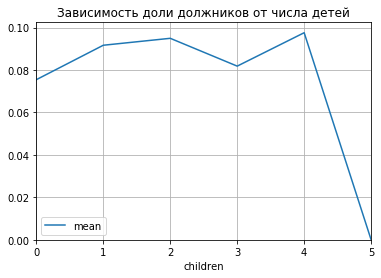

In [290]:
# построение графика зависимости доли должников от числа детей 
df.groupby('children')['debt'].agg(['mean']).plot(ylim=0, grid=True, title='Зависимость доли должников от числа детей');

**Вывод**

Доля должников среди клиентов, имеющих 0 – 4 детей приблизительно одинакова и составляет от 7,5 до 10%. В целом, доля должников в этой группе растет с ростом числа детей, однако, у клиентов с 3 детьми заметно меньше доля должников. Возможно, это связано с государственной помощью многодетным семьям (в рамках действующего законодательства многодетная семья – это ячейка общества, в которой родилось трое и более детей). 

Можно сказать, что у клиентов, не имеющих детей, меньше доля должников.

Среди клиентов, указавших 5 детей, задолжностей не было ни у одного. Вероятно, это связано с малым числом таких клиентов (9 человек).

**Есть ли зависимость между семейным положением и возвратом кредита в срок?**

Сгруппируем данные о семейном положении по группам. Для каждой группы расчитаем долю клиентов, имевших задолжность.

In [270]:
# группировка по значениям столбца family_status_id, подсчет кол-ва и среднего в каждой группе
df.groupby('family_status_id')['debt'].agg(['count', 'mean'])

,count,mean
family_status_id,,
0,12339,0.075452
1,4151,0.093471
2,959,0.065693
3,1195,0.071130
4,2810,0.097509


Число клиентов, состоящих в той или иной группе, бесполезно для ответа на данный вопрос. Сохраним долю должников в таблице `family_group`.

In [271]:
# группировка по значениям столбца family_status_id, подсчет среднего в каждой группе
family_group = df.groupby('family_status_id')['debt'].agg(['mean'])

Для наглядности добавим к таблице столбец с расшифровкой id из `family_dict`.

In [272]:
# добавление столбца family_status из таблицы family_dict
family_group = family_group.merge(family_dict, on='family_status_id', how='left')
family_group

,family_status_id,mean,family_status
0,0,0.075452,женат / замужем
1,1,0.093471,гражданский брак
2,2,0.065693,вдовец / вдова
3,3,0.071130,в разводе
4,4,0.097509,Не женат / не замужем


Отсортируем значения в порядке возрастания. Таким образом, верхние строки будут соответсвовать группам, где чаще всего возвращали кредиты в срок.

In [273]:
# сортировка значений в порядке возрастания
family_group.sort_values('mean')

,family_status_id,mean,family_status
2,2,0.065693,вдовец / вдова
3,3,0.071130,в разводе
0,0,0.075452,женат / замужем
1,1,0.093471,гражданский брак
4,4,0.097509,Не женат / не замужем


**Вывод**

Среди клиентов, не состоящие и не состоявшие в браке (Не женат / не замужем), самая большая доля тех, кто имел задолжности.
Чуть меньше эта доля сведи тех, кто состоит в гражданском браке. Стоит заметить, что гражданским браком принято считать незарегистрированное совместное проживание, когда как с юридической точки зрения, гражданский брак – это официально узаконенные в ЗАГСе отношения. Предположим, что это понятие используется в качестве синонима к незарегистророванным отношениям (доля должников в этой группе примерно равна доли должников в группе "Не женат / не замужем"). 

Среднее число задолжностей в трех других группах (женат / замужем, в разводе, вдовец / вдова) меньше и составляет примерно  7 %. Замечу, что группа клиентов, состоящих в браке самая многочисленная.

**Есть ли зависимость между уровнем дохода и возвратом кредита в срок?**

Поскольку обработка столбца `total_income` была сделана двумя способами, проанализируем данные дял каждого.

Сначала проанализируем отдельную таблицу, в которой были удалены пропущенные строки.

In [274]:
# группировка по значениям столбца total_income_group, подсчет кол-ва и среднего в каждой группе
income_group1 = income.groupby('total_income_group')['debt'].agg(['count', 'mean'])
income_group1

,count,mean
total_income_group,,
100 - 200 тыс,9822,0.087457
200 - 500 тыс,4844,0.071016
50 - 100 тыс,4091,0.080909
500 тыс - 1 млн,197,0.060914
< 50 тыс,372,0.061828
> 1 млн,25,0.080000


Больше всего кредитов берут клиенты со среднем доходом (100 - 200 тыс), меньше всего – с доходом более 1 миллиона.

Отсортируем таблицу по среднему числу должников

In [275]:
# сортировка значений в порядке возрастания
income_group1['mean'].sort_values()

total_income_group
500 тыс - 1 млн    0.060914
< 50 тыс           0.061828
200 - 500 тыс      0.071016
> 1 млн            0.080000
50 - 100 тыс       0.080909
100 - 200 тыс      0.087457
Name: mean, dtype: float64

Наибольшая доля должников оказалась группе со средним доходом (100 - 200 тыс), немного лучше дела обстоят в группах с доход 50 - 100 тыс и более 1 млн (при том, что это самая маленькая группа), однако разница составляет доли процента. Группы с доходом менее 50 тыс и 500 тыс - 1 млн показывают наилучший результат.

Проделаем те же операции значений из таблицы df, где пропущенные строки были заполнены медианой.

In [276]:
# группировка по значениям столбца total_income_group, подсчет кол-ва и среднего в каждой группе
income_group2 = df.groupby('total_income_group')['debt'].agg(['count', 'mean'])
income_group2

,count,mean
total_income_group,,
100 - 200 тыс,11925,0.086289
200 - 500 тыс,4844,0.071016
50 - 100 тыс,4091,0.080909
500 тыс - 1 млн,197,0.060914
< 50 тыс,372,0.061828
> 1 млн,25,0.080000


Значение группы со средним доходом (100 - 200 тыс) изменилось на доли процента, что несущественно для текущей задачи. Выводы для предыдущего подхода справедливы и в данном случае.

Проанализируем клиентов, не указавших свой доход

In [277]:
# доля должников, среди неуказавших доход
income_nan.mean()

total_income         NaN
debt            0.078197
dtype: float64

Доля должников среди них 7,8%. Это значение близко к средней доли должников по всем известным значениям.

In [278]:
# доля должников, среди указавших доход
income['debt'].mean()

0.0811844349129244

В итоге, оба подхода показали одинаковые результаты.

**Вывод**

Наибольшая доля клиентов, имевших задолжности, оказалась в самой могочисленной группе (100 - 200 тыс), в группах с доходом 50 - 100 тыс и более 1 млн (при том, что это самая маленькая группа).

Группы с доходом менее 50 тыс и 500 тыс - 1 млн показывают наилучший результат. 

Доля должников среди клиентов, не указавших доход, примерно равна средней доли среди тех клиентов, кто указал доход.

**Как разные цели кредита влияют на его возврат в срок?**

Сгруппируем данные по целям и в каждой группе посчитаем количесвтво клиентов и долю тех, у которых были задолжности.

In [279]:
# группировка по значениям столбца purpose, подсчет кол-ва и среднего в каждой группе
df.groupby('purpose')['debt'].agg(['count','mean'])

,count,mean
purpose,,
автомобиль,4306,0.093590
недвижимость,10811,0.072334
образование,4013,0.092200
свадьба,2324,0.080034


Ожидаемо, больше всего кредитов берут клиенты, планирующие потрать полученные средства на недвижимость.

Сохраним в таблице `purpose` только долю должников в каждой группе.

In [280]:
# группировка по значениям столбца purpose, подсчет среднего в каждой группе
purpose = df.groupby('purpose')['debt'].agg(['mean'])

Отсортируем значения в порядке возрастания.

In [281]:
# сортировка значений в порядке возрастания
purpose['mean'].sort_values()

purpose
недвижимость    0.072334
свадьба         0.080034
образование     0.092200
автомобиль      0.093590
Name: mean, dtype: float64

**Вывод**

Доля клиентов, имевших задолжности, наибольшая для тех, кто берет кредит на образование и автомобиль (9%). Наилучший результат 7% у группы клиентов, берущей кредит на недвижимость. 

## Шаг 4. Общий вывод

<a id='conclusion'></a>

При обработке данных были выявлены пропуски в столбцах `total_income` и в `days_employed` (доля пропусков 10%). В столбце `total_income` пропуски были заменены медианами, столбец `days_employed` удален. Возможно, некоторые клиенты по какой-либо причине не указали данные.

В столбце `total_income` был изменет тип данный с `float` на `int`.

Далее были обработы дубликаты. В столбце `education` были найдены дубликаты в разных регистрах. В стоблце `children` были найдены неожиданные значения -1 и 20, которые решено было считать опечатками. 

Была проведена лемматизация столбца `purpose` покольку в исходной таблицы цели были записаны по-разному. В результате все цели получения кредита разделились на четыре группы: недвижимость, свадьба, автомобиль, образование.

Для удобства дальнейшей работы была проведена категоризация. Для столбцов `family_status` и `family_status_id` cоздан отдельный «словарь», где названию статуса будет соответствовать id номер. Столбец `total_income` был разбит на группы по количеству дохода клиентов. Кроме того, были удалены колонки, не задействованные в исследовании.

В ходе исследования были даны ответы на следущие вопросы.


1. Есть ли зависимость между наличием детей и возвратом кредита в срок?

Можно утверждать, что клиенты, не имеющие детей, имеют меньший процент задолжностей. В целом, наблюдается небольшой рост процента задолжностей с ростом количества детей : от 7,5% у бездетных до 10% у клиентов с 4 детьми. Клиенты с 3 детьми несколько выбиваются из общей тенденции (доля должников в этой группе меньше, чем у других групп с детьми). Клиенты с 5 детьми не имели ни одной задолжности, однако их на порядки меньше, чем в других группах, поэтому делать какие-либо выводы по этой группе сделать сложно.

2. Есть ли зависимость между семейным положением и возвратом кредита в срок?

Да, зависимость есть. Среди клиентов, не состоящие и не состоявшие в браке (Не женат / не замужем / гражданский брак), самая большая доля тех, кто имел задолжности. 

3. Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

Да. Наибольшая доля клиентов, имевших задолжности, имеет доход от 50 до 200 тысяч, а также более 1 миллиона. Группы с доходом менее 50 тысяч и от 500 тысяч до 1 миллиона показывают наилучший результат

4. Как разные цели кредита влияют на его возврат в срок?

Клиенты, берущие кредит для вложения в недвижимость, имеют наименьший процент задолжностей. Среди клиентов, берущих кредит на  образование и автомобиль, доля должников наибольшая.

**Рекомендации**

* В столбце `children ` обнаружились опечатки. 
* В столбце `days_employed`, описывающем общий трудовой стаж, неверно указан формат данных (вероятно, данные представлены в формате UTC вместо заявленного количества дней).
* В стоблце `dob_years` обнаружились нулеве значения.
* В стоблце `education ` были обнаружены дубликаты в разных регистрах
* В стоблце `gender ` было найденно единстенное значение, отличное от двух представленных.
* В стоблце `total_income` обнаружены пропущенные значения в тех же строках, что и в столбце `days_employed`.
* В столбце `purpose ` обнаружены всего 4 цели, однако обозначены они несколькими способами.